In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import training as tr
import emnet

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable

## Write events to a DataFrame

In [ ]:
datfile = "/home/jrenner/local/data/electronsim/pixelated_tracks_thinned_4um_back_10M_300keV.txt"

In [ ]:
def read_electron_data(fname, nevts=1000):
    
    evt = -1
    xinc = 0.0
    yinc = 0.0
    front = True
    energy = 0.0
    
    # Open the file and read the specified number of events.
    l_evt, l_xinc, l_yinc, l_front, l_energy, l_row, l_col, l_counts = [], [], [], [], [], [], [], []
    evts_read = 0
    with open(fname) as f:
        
        # Iterate through all lines.
        for line in f:
            
            # Stop reading if we've read the specified number of events.
            if(evts_read > nevts):
                break
            
            # Get each number in the line, separated by spaces.
            vals = line.rstrip().split(" ")
            
            # Start a new event.
            if(vals[0] == "EV"):
                evt    = vals[1]
                xinc   = vals[2]
                yinc   = vals[3]
                front  = (vals[4] == 1)
                energy = vals[5]
                evts_read += 1
                
            # Add a row for the current event.
            else:
                l_evt.append(int(evt))
                l_xinc.append(float(xinc))
                l_yinc.append(float(yinc))
                l_front.append(front)
                l_energy.append(float(energy))
                l_row.append(int(vals[0]))
                l_col.append(int(vals[1]))
                l_counts.append(int(vals[2]))
    
    # Construct the DataFrame.
    evt_dict = {'event': l_evt, 'xinc': l_xinc, 'yinc': l_yinc, 'front': l_front, 
                'energy': l_energy, 'row': l_row, 'col': l_col, 'counts': l_counts}
    df = pd.DataFrame.from_dict(evt_dict)
    
    return df

In [ ]:
df = read_electron_data(datfile,nevts=10000)

In [ ]:
df.xinc.values[0]

In [ ]:
df.to_pickle("EM_4um_back_10M_300keV.pkl")

### Examine individual events

In [ ]:
evt_plt = 97
evt_arr = np.zeros([101,101])
df_evt = df[df.event == evt_plt]
for row,col,counts in zip(df_evt['row'].values,df_evt['col'].values,df_evt['counts'].values):
    evt_arr[row,col] += counts
plt.imshow(np.log(0.1 + evt_arr))
plt.colorbar()
plt.title("Event {}; max at {}".format(evt_plt,np.unravel_index(evt_arr.argmax(),evt_arr.shape)))

In [ ]:
max(df.xinc.values)

## Evaluate a dataset

In [ ]:
Nevts = 1000

In [ ]:
noise_arr = np.arange(0.,100.,50.)
r_mean, r_sigma = [], []
for noise in noise_arr:
    print("Running for noise",noise)
    dset = tr.EMDataset("EM_4um_back_10M_300keV.pkl",0,noise)
    
    shifts_x, shifts_y, shifts_r = [], [], []
    for evt in range(Nevts):
        evt_arr,evt_lbl = dset[evt]
        xs,ys = evt_lbl[0],evt_lbl[1]
        shifts_x.append(xs)
        shifts_y.append(ys)
        shifts_r.append((xs**2 + ys**2)**0.5)
    
    shifts_r = np.array(shifts_r)
    r_mean.append(np.mean(shifts_r))
    r_sigma.append(np.std(shifts_r))

In [ ]:
plt.errorbar(noise_arr,r_mean,yerr=np.array(r_sigma)/Nevts**0.5)
plt.xlabel("$\sigma$ noise (electrons)")
plt.ylabel("r-error (mm)")

### Read a dataset

In [ ]:
dset = tr.EMDataset("EM_4um_back_10M_300keV.pkl",0,70)

In [ ]:
evt_plt = 5
evt_item = dset[evt_plt]
evt_arr = evt_item[0]
evt_lbl = evt_item[1]
evt_err_ind = evt_item[2]
plt.imshow(evt_arr)
plt.colorbar()
plt.title("Event {}; shift {}; index {}".format(evt_plt,evt_lbl,evt_err_ind))

In [ ]:
shifts_x, shifts_y, shifts_r = [], [], []
for evt in range(1000):
    evt_arr,evt_lbl = dset[evt]
    xs,ys = evt_lbl[0],evt_lbl[1]
    shifts_x.append(xs)
    shifts_y.append(ys)
    shifts_r.append((xs**2 + ys**2)**0.5)

In [ ]:
plt.hist(shifts_r,bins=100)
plt.yscale('log')

#### For debugging the 3x3 sum operations

In [ ]:
aa = np.ones([6,6])
aa[0,2] = 4
aa[1,2] = 2
aa[3,2] = 8
aa[4,2] = -2
aa[3,1] = 5
aa[5,0] = 10
aa

In [ ]:
max_init   = np.unravel_index(aa.argmax(),aa.shape)
nbsum_init = tr.sum_neighbors(aa,max_init,remove=True)
print("Max at",max_init,"and neighbor sum",nbsum_init)
aa

## Train a network

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import training as tr
import emnet

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable

In [2]:
modeldir = '/home/jrenner/local/jerenner/emsim/models'
lrate       = 1e-4   # Learning rate to use in the training.
load_model  = True   # Load an existing model
tr.augment  = False  # Enable/disable data augmentation
epoch_start = 0      # Number of initial epoch
epoch_end   = 2000    # Number of final epoch
model_load_checkpoint = "{}/model_init_651.pt".format(modeldir)

# Create the datasets.
dataset_all   = tr.EMDataset("EM_4um_back_10M_300keV.pkl")
dataset_train = tr.EMDataset("EM_4um_back_10M_300keV.pkl",nstart=0,nend=-2000)
dataset_val   = tr.EMDataset("EM_4um_back_10M_300keV.pkl",nstart=-2000)

# Create the loaders.
train_loader = DataLoader(dataset_train, batch_size=200, shuffle=True, collate_fn=tr.my_collate, num_workers=4)
val_loader = DataLoader(dataset_val, batch_size=500, shuffle=True, collate_fn=tr.my_collate, num_workers=4)
#val_loader = DataLoader(dataset_val, batch_size=15, shuffle=True, collate_fn=tr.my_collate, num_workers=4)
#test_loader = DataLoader(dataset_test, batch_size=15, shuffle=True, collate_fn=tr.my_collate, num_workers=4)

# Define the model.
#model = emnet.FCNet()
model = emnet.basicCNN()
model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lrate, betas=(0.9, 0.999), eps=1e-6, weight_decay=0.01, amsgrad=True)

# Load the model from file.
if(load_model):
    model.load_state_dict(torch.load(model_load_checkpoint))
    #model.load_state_dict(torch.load(model_load_checkpoint,map_location=torch.device('cpu')))
    model.eval()

Created dataset for events from 0 to 9999
Created dataset for events from 0 to -2000
Created dataset for events from -2000 to 2000


In [ ]:
# Run the training.
#print("Training with weights",sort_clsweights)
for epoch in range(epoch_start,epoch_end):
    print("Epoch: ",epoch)
    model.train()
    tr.train(model, epoch, train_loader, optimizer)
    with torch.no_grad():
        model.eval()
        tr.val(model, epoch, val_loader)
#     if(epoch % 50 == 0):
#         torch.save(model.state_dict(), "{}/model_init_{}.pt".format(modeldir,epoch))

In [ ]:
torch.save(model.state_dict(), "{}/model_init_{}.pt".format(modeldir,epoch))

### Test the net

In [3]:
dset = tr.EMDataset("EM_4um_back_10M_300keV.pkl",0,0)
softmax = nn.Softmax(dim=1)
model.eval()

Created dataset for events from 0 to 9999


basicCNN(
  (conv1): Conv2d(1, 16, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool4): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=256, out_features=100, bias=True)
  (drop1): Dropout(p=0.5, inplace=False)
)

Text(0.5, 1.0, 'Incidence point within central pixel')

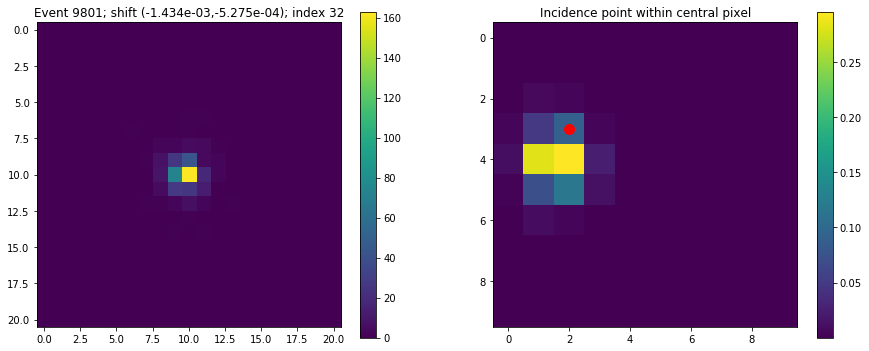

In [60]:
evt_plt = 9801
evt_item = dset[evt_plt]
evt_arr = evt_item[0]
evt_lbl = evt_item[1]
evt_err_ind = evt_item[2]

xbin = int(tr.ERR_SIZE*(evt_lbl[0] - tr.ERR_RANGE_MIN)/(tr.ERR_RANGE_MAX - tr.ERR_RANGE_MIN))
xbin = max(xbin,0)
xbin = min(xbin,tr.ERR_SIZE-1)

ybin = int(tr.ERR_SIZE*(evt_lbl[1] - tr.ERR_RANGE_MIN)/(tr.ERR_RANGE_MAX - tr.ERR_RANGE_MIN))
ybin = max(ybin,0)
ybin = min(ybin,tr.ERR_SIZE-1)

# Send through the model.
data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
target = torch.tensor(np.array(evt_err_ind)).long().cuda()

output_score = model(data)
prob = np.array(softmax(output_score).cpu().detach().numpy()).reshape([10,10])

fig = plt.figure()
fig.set_figheight(6.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(121);
plt.imshow(evt_arr)
plt.colorbar()
plt.title("Event {}; shift ({:.3e},{:.3e}); index {}".format(evt_plt,evt_lbl[0],evt_lbl[1],evt_err_ind))

ax2 = fig.add_subplot(122)
ax2.plot([xbin],[ybin],color='red',marker='o',markersize=10)
plt.imshow(prob)
plt.colorbar()
plt.title("Incidence point within central pixel")

In [59]:
# Look at many events:
xpred_err, ypred_err = [], []
for evt_plt in np.arange(9800,9900):
    
    evt_item = dset[evt_plt]
    evt_arr = evt_item[0]
    evt_lbl = evt_item[1]
    evt_err_ind = evt_item[2]

    # Send through the model.
    data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
    target = torch.tensor(np.array(evt_err_ind)).long().cuda()

    output_score = model(data)
    prob = np.argmax(np.array(softmax(output_score).cpu().detach().numpy()).reshape([10,10]))
    xpred = (evt_err_ind % tr.ERR_SIZE)*0.005/tr.ERR_SIZE + tr.ERR_RANGE_MIN
    ypred = (evt_err_ind / tr.ERR_SIZE)*0.005/tr.ERR_SIZE + tr.ERR_RANGE_MIN
    print("[Evt",evt_plt,"]: Index is",evt_err_ind,"with predicted",prob,"; x = {} (predicted {}), y = {} (predicted {})".format(evt_lbl[0],xpred,evt_lbl[1],ypred))
    
    xpred_err.append(xpred-evt_lbl[0])
    ypred_err.append(ypred-evt_lbl[1])
xpred_err = np.array(xpred_err)
ypred_err = np.array(ypred_err)

[Evt 9800 ]: Index is 91 with predicted 81 ; x = -0.00165571 (predicted -0.002), y = 0.00203062 (predicted 0.00205)
[Evt 9801 ]: Index is 32 with predicted 42 ; x = -0.00143403 (predicted -0.0015), y = -0.00052754 (predicted -0.0009)
[Evt 9802 ]: Index is 66 with predicted 65 ; x = 0.000658369 (predicted 0.0005), y = 0.000784166 (predicted 0.0007999999999999999)
[Evt 9803 ]: Index is 71 with predicted 71 ; x = -0.00157637 (predicted -0.002), y = 0.00137981 (predicted 0.0010499999999999997)
[Evt 9804 ]: Index is 59 with predicted 49 ; x = 0.00221525 (predicted 0.0019999999999999996), y = 0.000151773 (predicted 0.0004500000000000003)
[Evt 9805 ]: Index is 18 with predicted 8 ; x = 0.00193948 (predicted 0.0015), y = -0.0018208 (predicted -0.0015999999999999999)
[Evt 9806 ]: Index is 2 with predicted 2 ; x = -0.00124189 (predicted -0.0015), y = -0.0021476 (predicted -0.0024000000000000002)
[Evt 9807 ]: Index is 17 with predicted 17 ; x = 0.00128005 (predicted 0.0010000000000000005), y = -0

(array([  5,   7,  17,  18,  19,  32,  33,  37,  42,  51,  54,  56,  59,
         63,  65,  70,  73,  90,  92, 102, 108, 117, 119, 124, 130, 133,
        141, 143, 144, 145, 147, 152, 156, 159, 160, 163, 166, 167, 175,
        186, 187, 196, 211, 212, 214, 222, 224, 229, 241, 243, 262, 263,
        265, 271, 277, 283, 288, 291, 295, 299, 304, 309, 325, 326, 335,
        342, 345, 352, 354, 356, 370, 373, 376, 379, 382, 383, 385, 387,
        394, 398, 399, 403, 405, 406, 409, 413, 414, 418, 419, 429, 440,
        453, 460, 472, 486, 490, 496, 497]),)

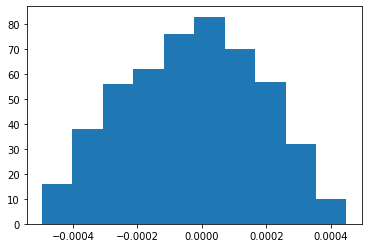

In [57]:
plt.hist(ypred_err)
np.where(abs(xpred_err) > 0.0004)